<a href="https://colab.research.google.com/github/JacopoKahl/vae_mnist/blob/main/Variational_Autoencoder_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Variational Autoencoder using the Functional API on MNIST dataset

Example of variatonal autoencode on MNIST

**Warning! This notebook will make use of Tensorflow 1.x**

since variational model can be problematic with TF 2.x

In [1]:
#Use previous version of TF

%tensorflow_version 1.x

TensorFlow 1.x selected.


##Imports

Import libraries and functions

In [2]:
#Keras imports
#from keras.models import Sequential #Sequential model class
from keras.models import Model #Functional model for generic acrhitectures

from keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Reshape
from keras.layers import Input #the Input layer is specific to the functional API and specifies the input dimensions
from keras.layers import Lambda #Lamda layer used for designing a custom layer function

#Import LeakyReLU activation function. It allows the learning algorithm to correct neuron's weight's if the output is zero (dead neuron)
from keras.layers.advanced_activations import LeakyReLU 

from keras.callbacks import ModelCheckpoint #import class for checkpointing the training process saving weights during progress
from keras.models import load_model #function for importing the whole model

#Import underlying backend (Tensorflow) to perform high-speed operations on tensors
import keras.backend as K

import numpy as np #numerical library numpy

#Import dataset
from keras.datasets import mnist

#Visualization
import matplotlib.pyplot as plt #visualization library

Using TensorFlow backend.


##Load dataset

In [3]:
#Load train and test data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

##Checking dataset

In [4]:
print('Dimensioni input training set: ', X_train.shape)
print('Dimensioni output training set: ', Y_train.shape)

print('Dimensioni input training set: ', X_test.shape)
print('Dimensioni output training set: ', Y_test.shape)

Dimensioni input training set:  (60000, 28, 28)
Dimensioni output training set:  (60000,)
Dimensioni input training set:  (10000, 28, 28)
Dimensioni output training set:  (10000,)


Label:  4


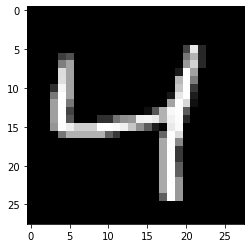

In [5]:
#Peeking into the training set

index = 2

plt.imshow(X_train[index], cmap='gray') #Show input image at index with grayscale colormap
print('Label: ', Y_train[index])

##Pre-processing the dataset

Normalizing and reshaping vectors

In [6]:
X_train = X_train.astype('float32') /255 #casting to float and normalizing input in the [0,1] interval
X_test = X_test.astype('float32') /255 #casting to float and normalizing input in the [0,1] interval

Reshaping input: creating two variables to hold dimensions info



In [7]:
#Forcing (#samples, width, height, #channels) dimensions with a reshape operation

train_dim = X_train.shape + (1, ) #input dimensions by concatenating original dims with (1,)
test_dim = X_test.shape + (1, ) #input dimensions by concatenating original dims with (1,)

print(train_dim)
print(test_dim)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [8]:
X_train = np.reshape(X_train, train_dim) #reshaping calling reshape method of the numpy library
X_test = np.reshape(X_test, test_dim) #reshaping calling reshape method of the numpy library

In [9]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


##Autoencoder model

**Note on the functional model:**
The functional model requires the layers to be defined in a pipeline where each layer if connected to the preceding layer and the following one.
The network is hten intended as a graph that can have arbitrary structure, not necessarily sequential.

###Network structure

In [10]:
inShape = X_train.shape[1:]
print('Single input shape: ', inShape)

latent_dim = 2 #Latent space dimension: 2D is easy to visualize, for better reconstruction performance try 16 or greater

imageDim = inShape[:2]

print('Image resolution: ', imageDim)

Single input shape:  (28, 28, 1)
Image resolution:  (28, 28)


## Encoder

Encoder network that creates representation in the latent space for input images.

In [11]:
'''
encoder = Sequential() #instance of the Sequential class

encoder.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape= inShape))
encoder.add(Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'))
encoder.add(Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'))
encoder.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))

encShapeBeforeFlatten = encoder.output_shape[1:] #save dimensions of output feature map before flattening
print('Encoder output shape before flatten: ', encShapeBeforeFlatten)

encoder.add(Flatten()) #flatten 2D output from previous layer into a 1D array

encoder.add(Dense(units=latent_dim, name='Latent_vector')) #NO activation!

encoder.summary()
'''

"\nencoder = Sequential() #instance of the Sequential class\n\nencoder.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape= inShape))\nencoder.add(Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'))\nencoder.add(Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'))\nencoder.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))\n\nencShapeBeforeFlatten = encoder.output_shape[1:] #save dimensions of output feature map before flattening\nprint('Encoder output shape before flatten: ', encShapeBeforeFlatten)\n\nencoder.add(Flatten()) #flatten 2D output from previous layer into a 1D array\n\nencoder.add(Dense(units=latent_dim, name='Latent_vector')) #NO activation!\n\nencoder.summary()\n"

**Note on the functional model:**

The functional model requires the layers to be defined in a pipeline where each layer if connected to the proceding layer and the following one.

The network is then intended as a graph thet can have arbitrary structure, not necessarily sequential.

Please note that in the logVar layer the following equivalence has been exploited:

$ \sigma = \exp(\log(\sigma)) = \exp(2*\log(\sigma)/2) = \exp(\log(\sigma^2)/2)$

**Note on the sampling function:**
the sampling function is coded to return

$ \mu + \epsilon*\sigma $

In [17]:
inputLayer = Input(shape=inShape, name='Encoder_input') #input layer

encoded = Conv2D(filters=32, kernel_size=3, strides=1, padding='same')(inputLayer)
encoded = LeakyReLU()(encoded) #LeakyRelu activation needs to be defined as separate layer

encoded = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(encoded)
encoded = LeakyReLU()(encoded) #LeakyRelu activation needs to be defined as separate layer

encoded = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(encoded)
encoded = LeakyReLU()(encoded) #LeakyRelu activation needs to be defined as separate layer

encoded = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(encoded)
encoded = LeakyReLU()(encoded) #LeakyRelu activation needs to be defined as separate layer

encShapeBeforeFlatten = encoded.shape[1:].as_list() #save dimensions of output feature map before flattening

print('Encoder output shape before flatten: ', encShapeBeforeFlatten)

encoded = Flatten()(encoded) #flatten 2D output from previous layer into a 1D array

encoded = Dense(units=latent_dim)(encoded)
#encoded is now the output of the main trunk of the encoder that will be taken as input to the following branches

#Now the model splits into mu and logVar layers
mu = Dense(units=latent_dim, name='mu')(encoded) #mu is the mean of the normal distribution that defines a given sample
logVar = Dense(units=latent_dim, name='Logvar')(encoded) #logVar defines the logarithm of the variance of the normal distribution

#print(K.shape(encoded))

def sampling(args): #definition of the sampling function that gets args as input list of arguments
  mu, logVar = args #split args list into component input
  epsilon = K.random_normal(shape=K.shape(encoded), mean=0. , stddev=1.) #epsilon is sampled from a normal distribution with mean=0 and std=1
  return mu + K.exp(logVar / 2)*epsilon


encoderOutput = Lambda(sampling, name='Encoder_output')([mu, logVar]) #Lambda layer for sampling the normal distribution for the input image

encoder = Model(inputLayer, encoderOutput, name='Encoder') #Create the encoder as instance of the Model class. 
#Note how the functional model requires the endpoints of the pipeline to be defined 

encoder.summary()

Encoder output shape before flatten:  [7, 7, 64]
Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 28, 32)   320         Encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 28, 28, 32)   0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 14, 14, 64)   18496       leaky_re_lu_9[0][0]              
___________________________________________

##Decoder

The deoder network reconstructs an image from vector in latent space.

In [13]:
'''
decoder = Sequential()

decoder.add(Dense(units=np.prod(encShapeBeforeFlatten), input_dim=latent_dim)) 
decoder.add(Reshape(encShapeBeforeFlatten)) #reshape input into encShapeBeforeFlatten resolution
decoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
decoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu', padding='same'))
decoder.add(Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu', padding='same'))
decoder.add(Conv2DTranspose(filters=1, kernel_size=3, strides=1, activation='sigmoid', padding='same'))

print(decoder.output_shape)
decoder.summary()
'''

"\ndecoder = Sequential()\n\ndecoder.add(Dense(units=np.prod(encShapeBeforeFlatten), input_dim=latent_dim)) \ndecoder.add(Reshape(encShapeBeforeFlatten)) #reshape input into encShapeBeforeFlatten resolution\ndecoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))\ndecoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu', padding='same'))\ndecoder.add(Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu', padding='same'))\ndecoder.add(Conv2DTranspose(filters=1, kernel_size=3, strides=1, activation='sigmoid', padding='same'))\n\nprint(decoder.output_shape)\ndecoder.summary()\n"

In [18]:
#Decoder with the function API

latentInput = Input(shape=(latent_dim,), name='Decoder_Input')

decoded = Dense(units=np.prod(encShapeBeforeFlatten), name='Decoder_FirstLayer')(latentInput)
decoded = Reshape(encShapeBeforeFlatten)(decoded)

decoded = Conv2DTranspose(filters=64, kernel_size=3, strides=1, padding='same')(decoded)
decoded = LeakyReLU()(decoded)

decoded = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same')(decoded)
decoded = LeakyReLU()(decoded)

decoded = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same')(decoded)
decoded = LeakyReLU()(decoded)

decoder_Output = Conv2DTranspose(filters=1, kernel_size=3, strides=1, activation='sigmoid', padding='same')(decoded)

decoder = Model(latentInput, decoder_Output, name='Decoder') #create the decoder as stand-alone model

decoder.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Decoder_Input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
Decoder_FirstLayer (Dense)   (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 14, 14, 64)        0   

##Autoencoder

In [ ]:
'''
autoencoder = Sequential()

autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.summary()
'''

In [19]:
#autoencoder = Model(inputLayer, decoder_Output) NO. Graph disconnected
autoencoder= Model(inputLayer, decoder(encoder(inputLayer))) #connects together the encoder and decoder

##Compile the autoencoder

Specify loss functions and optimizer.

The autoencoder now will work with two loss functions:

1. Reconstruction loss (vae_r_loss): distance between input and output
2. [Kullback-Lieber](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) loss (vae_kl_loss): distance between sample distribution and normal distribution with mean=0 and std=1

In [ ]:
#Specify loss function and optimizer
#autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

In [25]:
#Reconstruction loss
def vae_r_loss(y_true, y_pred):
  r_loss = K.mean(K.square(y_true - y_pred), axis=[1,2,3]) #compute mse between input and output images
  return r_loss #*1000 #the reconstruction loss has a wighting factor

def vae_kl_loss(y_true, y_pred):
  kl_loss= -0.5 * K.sum(1 + logVar - K.square(mu) - K.exp(logVar), axis=1) #Compute the KL loss between P(mean=mu, std=sigma) and Q(mean=0, std=1)
  return kl_loss

#Combined loss
def vae_loss(y_true, y_pred):
  r_loss = vae_r_loss(y_true, y_pred)
  kl_loss = vae_kl_loss(y_true, y_pred) 
  return 1000*r_loss + kl_loss #the reconstruction loss has a wighting factor

In [26]:
autoencoder.compile(loss=vae_loss, optimizer='adam', metrics=[vae_r_loss, vae_kl_loss])

##Training process

An autoencoder takes as output of the training function fit exactly the same dataset provided in input.

That is, the autoencoder has to learn to reproduce the input.

The learning process will make use of checkpoints to save progress.

In [28]:
#autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_data=(X_test, X_test))

#Note tha checkpoints will be saved only for better weights (that reduce the loss)
checkpointer = ModelCheckpoint(filepath='VAE_weights.h5', verbose=1, save_best_only=True)

hist = autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_data=(X_test, X_test), callbacks=[checkpointer])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 40s 666us/step - loss: 52.8571 - vae_r_loss: 0.0486 - vae_kl_loss: 4.2657 - val_loss: 51.8043 - val_vae_r_loss: 0.0473 - val_vae_kl_loss: 4.4727

Epoch 00001: val_loss improved from inf to 51.80429, saving model to VAE_weights.h5
Epoch 2/10
60000/60000 [==============================] - 40s 665us/step - loss: 50.8656 - vae_r_loss: 0.0465 - vae_kl_loss: 4.3562 - val_loss: 49.9725 - val_vae_r_loss: 0.0457 - val_vae_kl_loss: 4.3051

Epoch 00002: val_loss improved from 51.80429 to 49.97246, saving model to VAE_weights.h5
Epoch 3/10
60000/60000 [==============================] - 40s 662us/step - loss: 49.6941 - vae_r_loss: 0.0452 - vae_kl_loss: 4.4473 - val_loss: 49.5399 - val_vae_r_loss: 0.0451 - val_vae_kl_loss: 4.3958

Epoch 00003: val_loss improved from 49.97246 to 49.53992, saving model to VAE_weights.h5
Epoch 4/10
60000/60000 [==============================] - 40s 660us/step - l

##Visualization

In [29]:
#Generate output images corresponding to test input images

decodedImages = autoencoder.predict(X_test)

print(decodedImages.shape)

(10000, 28, 28, 1)


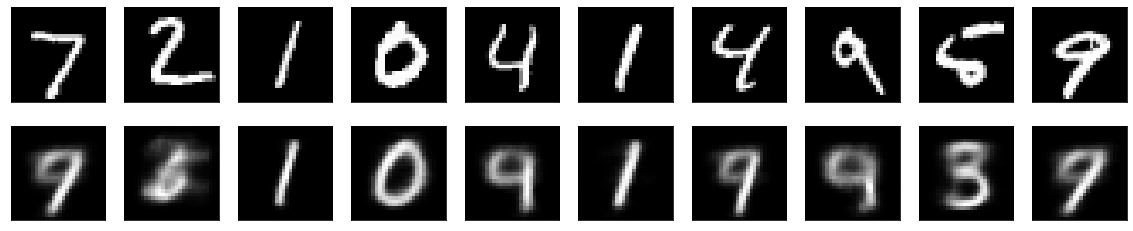

In [30]:
#The following coder plots a figure made of 10 images per row on two rows

n = 10 #number of subfigures per row

plt.figure(figsize=(20,4)) #total figure size in inches

for i in range(n): #for i in the range [0, n]
  #display original test images
  ax = plt.subplot(2, n, i+1) #create placeholder for the i-th image (plt works with index starting with 1 not 0)
  plt.imshow(X_test[i].reshape(28,28), cmap='gray') #show i-th image
  ax.get_xaxis().set_visible(False) #disable x axis visibility
  ax.get_yaxis().set_visible(False) #disable y axis visibility

  #display reconstructed test images
  ax = plt.subplot(2, n, i+1+n) #create placeholder for the i-th image (plt works with index starting with 1 not 0)
  plt.imshow(decodedImages[i].reshape(28,28), cmap='gray') #show i-th image
  ax.get_xaxis().set_visible(False) #disable x axis visibility
  ax.get_yaxis().set_visible(False) #disable y axis visibility

plt.show() #display entire image

##Show the latent space

Visualize the 2D vectors (points in a 2D space) generated by the encoder to represent test images.

In [31]:
X_test_encoded = encoder.predict(X_test) #create encoded vectors (embeddings) for input images using only the encoder model

print(X_test_encoded.shape)

(10000, 2)


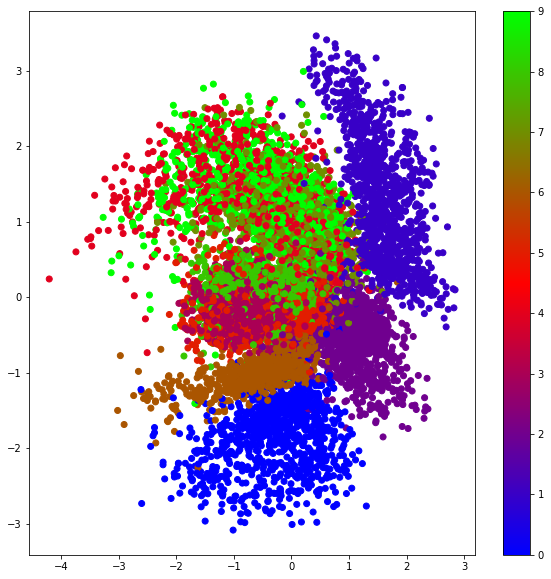

In [32]:
plt.figure(figsize=(10,10)) #figure of 10 inches
plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=Y_test, cmap='brg') #scatter plot of embeddings of test images
plt.colorbar()
plt.show()

##Sampling from the latent space to generate new digit

To sample from the latent space let's compute min and max values of encoded training samples.

In [ ]:
#Generate embeddings for training input images
X_train_encoded = encoder.predict(X_train)

In [ ]:
(lx_max, ly_max)= np.amax(X_train_encoded, axis=0) #max x and y values in the latent space
(lx_min, ly_min)= np.amin(X_train_encoded, axis=0) #min x and y values in the latent space

print('Max x: ', lx_max)
print('Min x: ', lx_min)
print('Max y: ', ly_max)
print('Min y: ', ly_min)

Max x:  11.87346
Min x:  -24.86868
Max y:  15.967457
Min y:  -5.894373


Let's perform uniform sampling in the 2D latent space with the above bounds

In [ ]:
sampleX = np.random.uniform(lx_min, lx_max)
sampleY = np.random.uniform(ly_min, ly_max)

print('Sampled vector: ', sampleX, sampleY)

Sampled vector:  2.4308475483937677 10.21244528078546


In [ ]:
#Create array as input to the decoder
sample = np.array([sampleX, sampleY])
print(sample.shape)

sample = np.reshape (sample, (1,)+sample.shape)
print(sample.shape)

#Decode sample vector

decodedSample = decoder.predict(sample)
print(decodedSample.shape)

(2,)
(1, 2)
(1, 28, 28, 1)


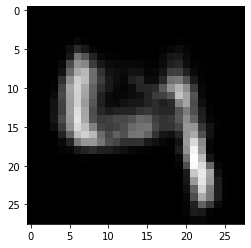

In [ ]:
plt.imshow(decodedSample.reshape(28,28), cmap='gray')